In [13]:
from pymongo import MongoClient
import pandas as pd

# Conexión a MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["ecommerce_cross"]

# Cargar datos desde MongoDB
users = pd.DataFrame(list(db.users.find()))
products = pd.DataFrame(list(db.products.find()))
interactions = pd.DataFrame(list(db.interactions.find()))

# Mostrar una muestra de los datos cargados
print("Usuarios:")
print(users.head())
print("\nProductos:")
print(products.head())
print("\nInteracciones:")
print(interactions.head())

Usuarios:
  _id              name                          email              created_at
0   1    Jonathan Ramos      gibsonpatrick@example.net 2023-06-05 19:27:07.126
1   2    Michelle Hardy        joshuayoung@example.org 2022-04-08 01:30:01.766
2   3     Rebecca Evans  hernandezsamantha@example.net 2022-11-15 17:30:09.448
3   4  Richard Woodward      jenkinsdillon@example.net 2022-02-13 14:19:41.993
4   5       Billy Lopez          anthony69@example.org 2020-08-20 21:28:00.124

Productos:
  _id                                       name  category   price  \
0   1          Switchable eco-centric monitoring      Home   85.50   
1   2  Reverse-engineered human-resource adapter  Clothing  268.94   
2   3       Switchable well-modulated initiative    Beauty  339.45   
3   4           Down-sized transitional software  Clothing  314.75   
4   5      Mandatory 4thgeneration system engine     Books  249.30   

               created_at  
0 2024-01-25 20:59:44.882  
1 2021-09-23 12:44:38.378  

In [14]:
# Unir las interacciones con los nombres de usuario y producto
interactions = interactions.merge(users, left_on="user_id", right_on="_id", how="left")
interactions = interactions.merge(products, left_on="product_id", right_on="_id", how="left")

# Crear matriz de interacción usuario-producto
interaction_matrix = interactions.pivot_table(
    index="name_x",  # Nombre del usuario
    columns="name_y",  # Nombre del producto
    values="interaction",
    fill_value=0
)

# Mostrar una muestra de la matriz
print("Matriz de interacción (user-product):")
print(interaction_matrix.head())

Matriz de interacción (user-product):
name_y          Adaptive 5thgeneration software  \
name_x                                            
Aaron Dennis                                0.0   
Aaron Maynard                               2.0   
Aaron Morrison                              0.0   
Aaron Thomas                                0.0   
Aaron Wong                                  0.0   

name_y          Adaptive full-range Internet solution  \
name_x                                                  
Aaron Dennis                                      0.0   
Aaron Maynard                                     0.0   
Aaron Morrison                                    0.0   
Aaron Thomas                                      0.0   
Aaron Wong                                        1.5   

name_y          Adaptive local help-desk  Adaptive radical neural-net  \
name_x                                                                  
Aaron Dennis                         0.0                  

In [15]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.sparse import csr_matrix
import pandas as pd

# Ejemplo de interacción: Asegúrate de cargar tu `interaction_matrix` real
# interaction_matrix = pd.read_csv('path/to/your/interaction_matrix.csv')

# Convertir matriz a formato disperso
sparse_matrix = csr_matrix(interaction_matrix)

# Entrenar modelo KNN
knn_model = NearestNeighbors(metric="cosine", algorithm="brute")
knn_model.fit(sparse_matrix)
print("Modelo KNN entrenado correctamente.")

# Función para evaluar el modelo KNN
def evaluate_knn(interaction_matrix, knn_model, k=5):
    """
    Evalúa el modelo KNN con precisión, recall y F1.
    
    Args:
        interaction_matrix (pd.DataFrame): Matriz de interacciones usuario-producto.
        knn_model: Modelo KNN entrenado.
        k (int): Número de recomendaciones a evaluar.
    
    Returns:
        dict: Métricas de evaluación (Precisión, Recall, F1).
    """
    y_true = []
    y_pred = []

    for user_index in range(interaction_matrix.shape[0]):
        # Obtener vecinos del usuario actual
        distances, indices = knn_model.kneighbors(
            interaction_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=k+1
        )
        
        # Excluir al propio usuario
        similar_users = indices.flatten()[1:]
        
        # Productos relevantes (verdaderos)
        relevant_products = interaction_matrix.iloc[user_index].to_numpy().nonzero()[0]
        
        # Productos recomendados (predichos)
        recommended_products = (
            interaction_matrix.iloc[similar_users]
            .sum(axis=0)
            .sort_values(ascending=False)
            .head(k)
            .index
        )
        
        # Crear listas de verdad y predicción
        y_true.extend([1 if i in relevant_products else 0 for i in range(interaction_matrix.shape[1])])
        y_pred.extend([1 if i in recommended_products else 0 for i in range(interaction_matrix.shape[1])])
    
    # Calcular métricas
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {"Precision": precision, "Recall": recall, "F1": f1}

# Evaluar el modelo
metrics = evaluate_knn(interaction_matrix, knn_model, k=5)
print(f"Evaluación del modelo KNN:\nPrecisión: {metrics['Precision']:.4f}\nRecall: {metrics['Recall']:.4f}\nF1: {metrics['F1']:.4f}")

# Depuración adicional para verificar resultados
print("\nDepuración:")
print(f"Tamaño de la matriz: {interaction_matrix.shape}")
print(f"Interacciones totales no nulas: {interaction_matrix.sum().sum()}")
print(f"Primeras filas de la matriz:\n{interaction_matrix.head()}")



Modelo KNN entrenado correctamente.
Evaluación del modelo KNN:
Precisión: 0.0000
Recall: 0.0000
F1: 0.0000

Depuración:
Tamaño de la matriz: (991, 500)
Interacciones totales no nulas: 126709.0
Primeras filas de la matriz:
name_y          Adaptive 5thgeneration software  \
name_x                                            
Aaron Dennis                                0.0   
Aaron Maynard                               2.0   
Aaron Morrison                              0.0   
Aaron Thomas                                0.0   
Aaron Wong                                  0.0   

name_y          Adaptive full-range Internet solution  \
name_x                                                  
Aaron Dennis                                      0.0   
Aaron Maynard                                     0.0   
Aaron Morrison                                    0.0   
Aaron Thomas                                      0.0   
Aaron Wong                                        1.5   

name_y          Adap

In [16]:
# Elegir un usuario aleatorio para probar
user_name = interaction_matrix.index[0]  # Primer usuario en la matriz
print(f"Probando recomendaciones para el usuario: {user_name}")

# Obtener los usuarios similares
user_index = interaction_matrix.index.get_loc(user_name)
distances, indices = knn_model.kneighbors(
    interaction_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=6
)

# Excluir al propio usuario y obtener usuarios similares
similar_users = indices.flatten()[1:]
print(f"Usuarios similares a {user_name}: {interaction_matrix.index[similar_users].tolist()}")
# Recomendar productos basados en usuarios similares
recommended_products = interaction_matrix.iloc[similar_users].sum(axis=0).sort_values(ascending=False)
recommended_products = recommended_products[interaction_matrix.loc[user_name] == 0]

# Mostrar productos recomendados
print(f"Productos recomendados para {user_name}:")
print(recommended_products.head())

# Combinar con los nombres de los productos
recommended_products_df = recommended_products.head().reset_index()
recommended_products_df.columns = ["Producto", "Relevancia"]

print(recommended_products_df)

Probando recomendaciones para el usuario: Aaron Dennis
Usuarios similares a Aaron Dennis: ['Anthony Hall', 'Jennifer Thompson', 'Bonnie Austin', 'Andrea Andrews', 'James Morgan']
Productos recomendados para Aaron Dennis:
name_y
Public-key context-sensitive collaboration    6.0
Phased intermediate toolset                   5.0
Centralized tertiary protocol                 5.0
Ergonomic 3rdgeneration software              5.0
Versatile zero tolerance service-desk         5.0
dtype: float64
                                     Producto  Relevancia
0  Public-key context-sensitive collaboration         6.0
1                 Phased intermediate toolset         5.0
2               Centralized tertiary protocol         5.0
3            Ergonomic 3rdgeneration software         5.0
4       Versatile zero tolerance service-desk         5.0


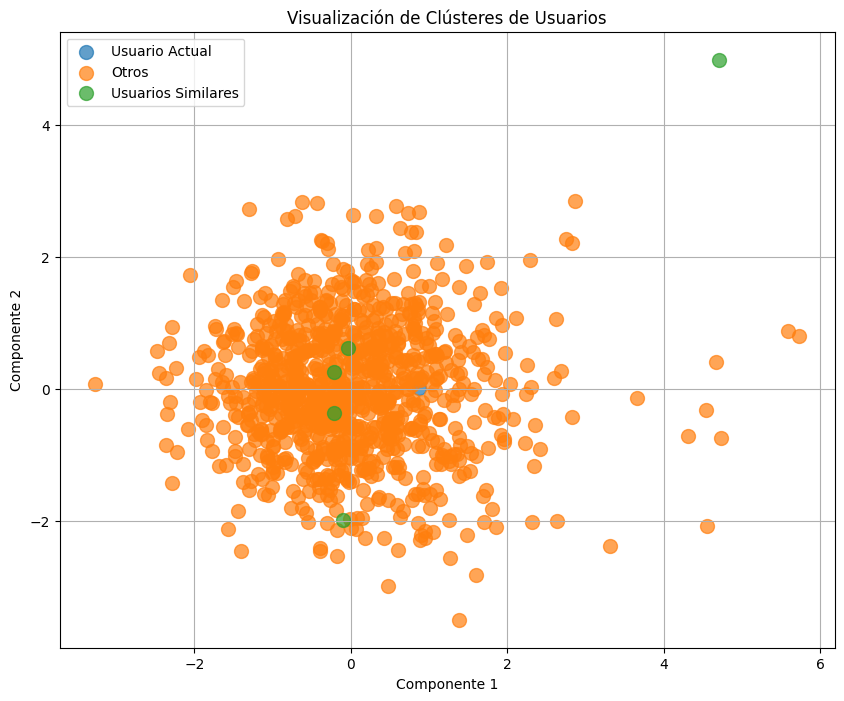

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

def plot_all_clusters(interaction_matrix, user_name, similar_users, knn_model):
    # Reducir dimensionalidad con PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(interaction_matrix)
    
    # Crear DataFrame para los datos reducidos
    reduced_df = pd.DataFrame(reduced_data, columns=["Componente 1", "Componente 2"], index=interaction_matrix.index)
    reduced_df["Tipo"] = "Otros"
    
    # Identificar el usuario actual y similares
    reduced_df.loc[user_name, "Tipo"] = "Usuario Actual"
    reduced_df.loc[similar_users, "Tipo"] = "Usuarios Similares"
    
    # Generar los clústeres basados en el modelo KNN
    cluster_labels = []
    for i in range(len(interaction_matrix)):
        distances, indices = knn_model.kneighbors(interaction_matrix.iloc[i, :].values.reshape(1, -1), n_neighbors=6)
        cluster_labels.append(indices.flatten()[1:].tolist())
    
    # Agregar los clusters como una columna (opcional para análisis avanzado)
    reduced_df["Cluster"] = cluster_labels
    
    # Graficar todos los usuarios
    plt.figure(figsize=(10, 8))
    for tipo in reduced_df["Tipo"].unique():
        subset = reduced_df[reduced_df["Tipo"] == tipo]
        plt.scatter(subset["Componente 1"], subset["Componente 2"], label=tipo, alpha=0.7, s=100)
    
    # Personalizar gráfico
    plt.title("Visualización de Clústeres de Usuarios")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar todos los clústeres
similar_users_names = interaction_matrix.index[similar_users].tolist()
plot_all_clusters(interaction_matrix, user_name, similar_users_names, knn_model)



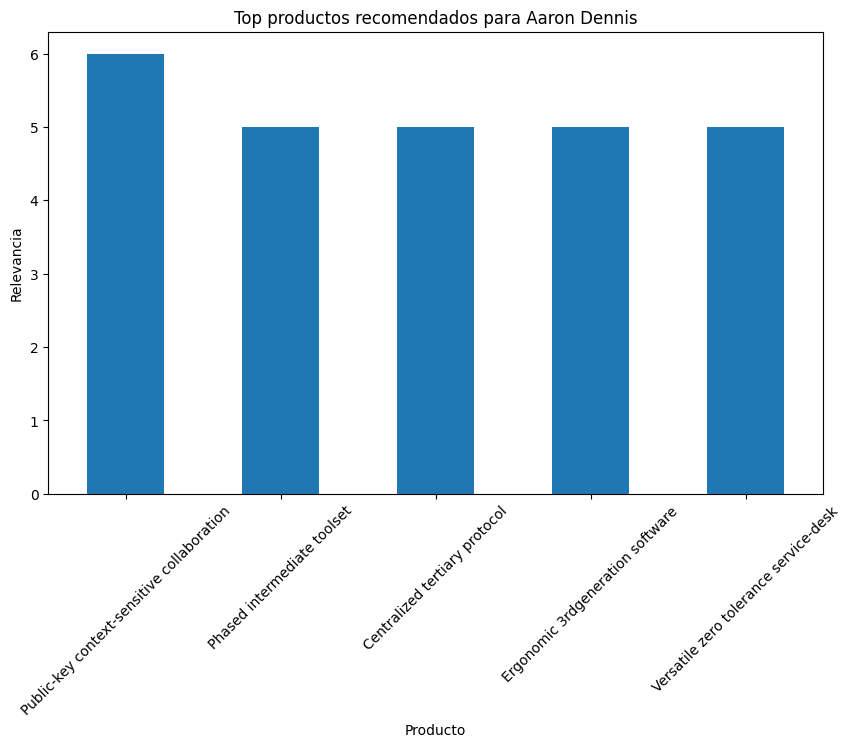

In [18]:
import matplotlib.pyplot as plt

# Graficar los productos recomendados
recommended_products_df.plot(
    x="Producto", y="Relevancia", kind="bar", figsize=(10, 6), legend=False
)
plt.title(f"Top productos recomendados para {user_name}")
plt.xlabel("Producto")
plt.ylabel("Relevancia")
plt.xticks(rotation=45)
plt.show()

In [19]:
import pickle

# Guardar modelo KNN
with open("knn_model_with_names.pkl", "wb") as f:
    pickle.dump(knn_model, f)

print("Modelo guardado correctamente.")

Modelo guardado correctamente.
